# COMP47590: Advanced Machine Learning
# Assignment 1: Benchmarking Esemble Methods

Name: Lucas George Sipos

Student Number: 24292215

Datasets: https://drive.google.com/drive/folders/1Q4nONzSPwcRX7vRiJ1nL9O2M_cfc8D8g?usp=drive_link

## Import Packages Etc

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
%matplotlib inline
import copy
import time
import pickle
import random
from pprint import pprint
from collections import Counter, defaultdict
from sklearn.utils import check_X_y
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, ParameterSampler, cross_validate, StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

## Task 1: Define HyperParamClassifier

HyperParamClassifier class.

In [2]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class HyperParamClassifier(BaseEstimator, ClassifierMixin):
    """An ensemble classifier that trains multiple instances of a given estimator
    with randomly sampled hyperparameters.

    Parameters
    ----------
    estimator : object
        The base estimator to be used for training multiple models.
    n_estimators : int, default=100
        The number of models to train with different hyperparameter configurations.
    param_grid : dict, default=None
        A dictionary where keys are parameter names and values are lists of values to sample from.
        If None, the base estimator's default parameters are used.
    random_state : int, default=None
        Controls randomness in hyperparameter sampling for reproducibility.

    Attributes
    ----------
    estimators_ : list
        A list of trained estimators with sampled hyperparameters.
    classes_ : array-like
        The unique class labels observed in the training data.

    Notes
    -----
    This classifier randomly samples hyperparameters from the given `param_grid` and trains multiple
    instances of `estimator`. The final prediction is determined by majority voting.

    See also
    --------
    sklearn.ensemble.RandomForest : A similar approach that trains multiple estimators.
    sklearn.model_selection.ParameterSampler : Used for hyperparameter sampling.
        .. deprecated:: 1.0 `ParameterSampler` is deprecated in 1.0 and will be removed in 1.1.
    Uses : Randomly sampled hyperparameters.

    Examples
    --------
    >>> from sklearn.tree import DecisionTreeClassifier
    >>> param_grid = {'max_depth': [3, 5, 10], 'min_samples_split': [2, 4, 6]}
    >>> clf = HyperParamClassifier(DecisionTreeClassifier(), n_estimators=10, param_grid=param_grid, random_state=42)
    >>> clf.fit(X_train, y_train)
    >>> y_pred = clf.predict(X_test)
    """

    def __init__(self, estimator, n_estimators=100, *, param_grid=None, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.param_grid = param_grid
        self.random_state = random_state
        self.estimators_ = []
        self.classes_ = []

        if random_state is not None:
            random.seed(random_state)

    def _sample_params(self):
        """Randomly sample hyperparameters from `param_grid`.

        Returns
        -------
        params : dict
            A dictionary of randomly sampled hyperparameters.
        """
        if not self.param_grid:
            return {}

        params = {}
        for param, values in self.param_grid.items():
            params[param] = random.choice(values)
        return params

    def fit(self, X, y):
        """Build a HyperParamClassifier classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
            Fitted estimator.
        """
        X, y = check_X_y(X, y)
        self.classes_ = np.unique(y)  # Store unique class labels for cross-validation

        self.estimators_ = []

        for _ in range(self.n_estimators):
            est = copy.deepcopy(self.estimator)

            # Set sampled parameters
            params = self._sample_params()
            for param, value in params.items():
                setattr(est, param, value)

            est.fit(X, y)
            self.estimators_.append(est)

        return self

    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        majority_vote : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        if not self.estimators_ or len(self.estimators_) != self.n_estimators:
            raise ValueError("Classifier has not been fitted yet.")

        predictions = np.array([model.predict(X) for model in self.estimators_])
        majority_vote = np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)
        return majority_vote

    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        if not self.estimators_ or len(self.estimators_) != self.n_estimators:
            raise ValueError("Classifier has not been fitted yet.")

        probas = np.array([model.predict_proba(X) for model in self.estimators_])
        avg_probas = np.mean(probas, axis=0)
        return avg_probas

## Test the HyperParamClassifier

Perform a simple test using the HyperParamClassifier on the Iris dataset

In [3]:
from sklearn.datasets import load_iris

iris = load_iris()
clf = HyperParamClassifier(DecisionTreeClassifier())
clf.fit(iris.data, iris.target)
y_pred = clf.predict(iris.data)
print(classification_report(iris.target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(iris.target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150

Confusion Matrix


Predicted,0,1,2,All
True,,,,
0,50,0,0,50
1,0,50,0,50
2,0,0,50,50
All,50,50,50,150


Perform a cross validation experiment

In [4]:
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

[1.         0.93333333 1.         0.93333333 0.93333333 0.86666667
 0.93333333 1.         1.         1.        ]
0.96  +/-  0.044221663871405324


## Task 2: Design the Evaluation Experiment

### Setup

Setup a number of estimators to be used

In [5]:
n_estimators = 20

Setup a cv folds for the StratifiedKFold

In [6]:
cv_folds = 3

Set up a dictionary to store simple model performance comparison

In [7]:
model_evaluation_results = dict()

### Setup Models

Setup a dictionary of models and the hyperparameter tuning used for our _HyperParamClassifier_.

In [8]:
models = dict()

Decision Tree

In [9]:
model_details = dict()
model_details['estimator'] = DecisionTreeClassifier()
model_details['param_grid'] = {
    'criterion': ['gini', "entropy"],
    'max_depth': [3, *list(range(5, 20, 5))],
    'min_samples_leaf': [3, 5, 10, 20],
    'min_samples_split': [2, 10, 20, 50]
}
models['decision_tree'] = model_details

Random Forest

In [10]:
model_details = dict()
model_details['estimator'] = RandomForestClassifier(min_samples_split=200, n_estimators=n_estimators, n_jobs=-1)
model_details['param_grid'] = {
    'max_features': list(range(2, 10, 2)),
    'min_samples_split': [50, 100, 200]
}
models['random_forest'] = model_details

Stochastic Gradient Descent

In [11]:
model_details = dict()
model_details['estimator'] = SGDClassifier(n_jobs=-1, early_stopping=True)
model_details['param_grid'] = {
    'loss': ['perceptron', 'squared_error'],
    'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l1', 'l2'],
    'max_iter': [750, 1000, 1250]
}
models['SGD'] = model_details

Multi-Layer Perceptron

In [12]:
model_details = dict()
model_details['estimator'] = MLPClassifier(activation='relu', solver='adam', early_stopping=True)
model_details['param_grid'] = {
    'hidden_layer_sizes': [(50,), (100,), (20, 20), (50, 50)],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [300, 400, 500]
}
model_details['n_estimators'] = 10
models['MLP'] = model_details

### Setup Datasets

Set up a dictionary to store details of datasets to be used in the experiment

In [13]:
datasets = dict()

Load the dataset and explore it.

In [14]:
dataset_details = dict()
dataset_details["file_name"] = '../Data/red_wine_qt.csv'
dataset_details["target_feature"] = "quality"
dataset_details["num_classes"] = 2
dataset_details["classes"] = {0: "bad", 1: "good"}
datasets["red_wine"] = dataset_details

In [15]:
dataset_details = dict()
dataset_details["file_name"] = '../Data/mnist_train.csv'
dataset_details["target_feature"] = "label"
dataset_details["num_classes"] = 10
dataset_details["classes"] = {0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9"}
datasets["mnist"] = dataset_details

In [16]:
dataset_details = dict()
dataset_details["file_name"] = '../Data/fashion-mnist_train.csv'
dataset_details["target_feature"] = "label"
dataset_details["num_classes"] = 10
dataset_details["classes"] = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal",
                              6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}
datasets["mnist_fashion"] = dataset_details

In [17]:
dataset_details = dict()
dataset_details["file_name"] = '../Data/kmnist.csv'
dataset_details["target_feature"] = "label"
dataset_details["num_classes"] = 10
dataset_details["classes"] = {0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9"}
datasets["kmnist"] = dataset_details

In [18]:
dataset_details = dict()
dataset_details["file_name"] = '../Data/sign_mnist_train.csv'
dataset_details["target_feature"] = "label"
dataset_details["num_classes"] = 24
dataset_details["classes"] = {0: "a", 1: "b", 2: "c", 3: "d", 4: "e", 5: "f", 6: "g", 7: "h", 8: "i", 10: "k", 11: "l",
                              12: "m", 13: "n", 14: "o", 15: "p", 16: "q", 17: "r", 18: "s", 19: "t", 20: "u", 21: "v",
                              22: "w", 23: "x", 24: "y"}
datasets["mnist_sign"] = dataset_details

## Task 3: Execute Evalution Experiment

Automated model training and evaluation across all datasets and algorithms

In [19]:
data_model_evaluation_results = dict()

for dataset_name in datasets:
    print(dataset_name)
    dataset_details = datasets[dataset_name]

    file_name = dataset_details["file_name"]
    target_feature = dataset_details["target_feature"]
    num_classes = dataset_details["num_classes"]
    classes = dataset_details["classes"]

    dataset = pd.read_csv(file_name)

    X = dataset.loc[:, dataset.columns != target_feature].values
    y = dataset[target_feature].values

    model_evaluation_results = defaultdict(dict)

    X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, train_size=0.8,
                                                                    random_state=42, stratify=y)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, train_size=0.75,
                                                          random_state=42, stratify=y_train_valid)

    for model_name, model_details in models.items():
        print(f"\t{model_name}")

        # Initialize HyperParamClassifier
        print('\t\tPerforming fit on HyperParamClassifier')
        hpc_model = HyperParamClassifier(
            estimator=model_details['estimator'],
            param_grid=model_details.get('param_grid', None),
            n_estimators=model_details.get('n_estimators', n_estimators),
            random_state=42
        )

        # Fit the model on the training set
        print('\t\tFitting and evaluating model')
        hpc_model.fit(X_train, y_train)

        # Evaluate on the test set
        y_pred = hpc_model.predict(X_test)

        test_accuracy = accuracy_score(y_test, y_pred)
        test_f1 = f1_score(y_test, y_pred, average='macro')

        model_evaluation_results[model_name]['dataset_name'] = dataset_name
        model_evaluation_results[model_name]['test_accuracy'] = test_accuracy
        model_evaluation_results[model_name]['test_f1'] = test_f1

        print(f"\t\tTest Accuracy: {test_accuracy:.4f}")
        print(f"\t\tTest F1-score: {test_f1:.4f}")

        # Final test (cross-validation on the validation set)
        print('\t\tPerforming final cross-validation on validation set')
        skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        final_cv_results = cross_validate(hpc_model, X_valid, y_valid, cv=skf, scoring=['accuracy', 'f1_macro'],
                                          n_jobs=-1)

        model_evaluation_results[model_name]['final_cv_results'] = final_cv_results
        model_evaluation_results[model_name]['final_cv_accuracy_mean'] = final_cv_results['test_accuracy'].mean()
        model_evaluation_results[model_name]['final_cv_accuracy_std_dev'] = final_cv_results['test_accuracy'].std()
        model_evaluation_results[model_name]['final_cv_f1_mean'] = final_cv_results['test_f1_macro'].mean()
        model_evaluation_results[model_name]['final_cv_f1_std_dev'] = final_cv_results['test_f1_macro'].std()

        print(f"\t\tValidation Accuracy: {model_evaluation_results[model_name]['final_cv_accuracy_mean']:.4f} +/- "
              f"{model_evaluation_results[model_name]['final_cv_accuracy_std_dev']:.4f}")
        print(f"\t\tValidation F1-score: {model_evaluation_results[model_name]['final_cv_f1_mean']:.4f} +/- "
              f"{model_evaluation_results[model_name]['final_cv_f1_std_dev']:.4f}")

    # Save results
    with open(f'evaluation_results_{time.strftime("%Y%m%d_%H%M%S")}.data', 'wb') as f:
        pickle.dump(dict(model_evaluation_results), f)

red_wine
	decision_tree
		Performing fit on HyperParamClassifier
		Fitting and evaluating model
		Test Accuracy: 0.8500
		Test F1-score: 0.3165
		Performing final cross-validation on validation set
		Validation Accuracy: 0.8531 +/- 0.0048
		Validation F1-score: 0.3106 +/- 0.0019
	random_forest
		Performing fit on HyperParamClassifier
		Fitting and evaluating model
		Test Accuracy: 0.8656
		Test F1-score: 0.3135
		Performing final cross-validation on validation set
		Validation Accuracy: 0.8625 +/- 0.0038
		Validation F1-score: 0.4631 +/- 0.0011
	SGD
		Performing fit on HyperParamClassifier
		Fitting and evaluating model
		Test Accuracy: 0.8594
		Test F1-score: 0.3086
		Performing final cross-validation on validation set
		Validation Accuracy: 0.8250 +/- 0.0157
		Validation F1-score: 0.4200 +/- 0.1630
	MLP
		Performing fit on HyperParamClassifier
		Fitting and evaluating model
		Test Accuracy: 0.8656
		Test F1-score: 0.4640
		Performing final cross-validation on validation set
		Validat

### Experiment Results Summary
Present a series of tables and graphs illustraitng experiment results.

Read the saved results from a run.

In [27]:
files = ['results_3/' + f for f in os.listdir('results_3')
         if f.startswith('evaluation_results_') and f.endswith('.data')]
# Sort by time created
files.sort(key=lambda x: os.path.getmtime(x))

model_evaluation_results = {}

for filename in files:
    with open(filename, 'rb') as f:
        temp = pickle.load(f)

    # Format the data we need
    for model_name, sub_dict in temp.items():
        if model_name not in model_evaluation_results:
            model_evaluation_results[model_name] = defaultdict(list)
        model_evaluation_results[model_name]['dataset_name'].append(sub_dict['dataset_name'])
        model_evaluation_results[model_name]['test_accuracy'].append(sub_dict['test_accuracy'])
        model_evaluation_results[model_name]['final_cv_accuracy_mean'].append(
            sub_dict['final_cv_accuracy_mean'])
        model_evaluation_results[model_name]['test_f1'].append(sub_dict['test_f1'])
        model_evaluation_results[model_name]['final_cv_f1_mean'].append(sub_dict['final_cv_f1_mean'])

Extract the data and plot the tables and graphs of test and validations sets for accuracy and f1-score

Test Accuracy Table:
                decision_tree  random_forest     SGD     MLP
Dataset                                                    
kmnist                0.6099         0.8795  0.8020  0.9185
mnist                 0.7892         0.9389  0.9109  0.9692
mnist_fashion         0.7497         0.8447  0.8407  0.8680
mnist_sign            0.3859         0.9363  0.8947  0.1675
red_wine              0.8500         0.8656  0.8594  0.8656

Validation Accuracy Table:
                decision_tree  random_forest     SGD     MLP
Dataset                                                    
kmnist                0.6357         0.8097  0.7559  0.8574
mnist                 0.8196         0.9007  0.8941  0.9412
mnist_fashion         0.7768         0.8130  0.8209  0.8371
mnist_sign            0.4274         0.7035  0.7756  0.0672
red_wine              0.8531         0.8625  0.8250  0.8625

Test F1 Table:
                decision_tree  random_forest     SGD     MLP
Dataset                         

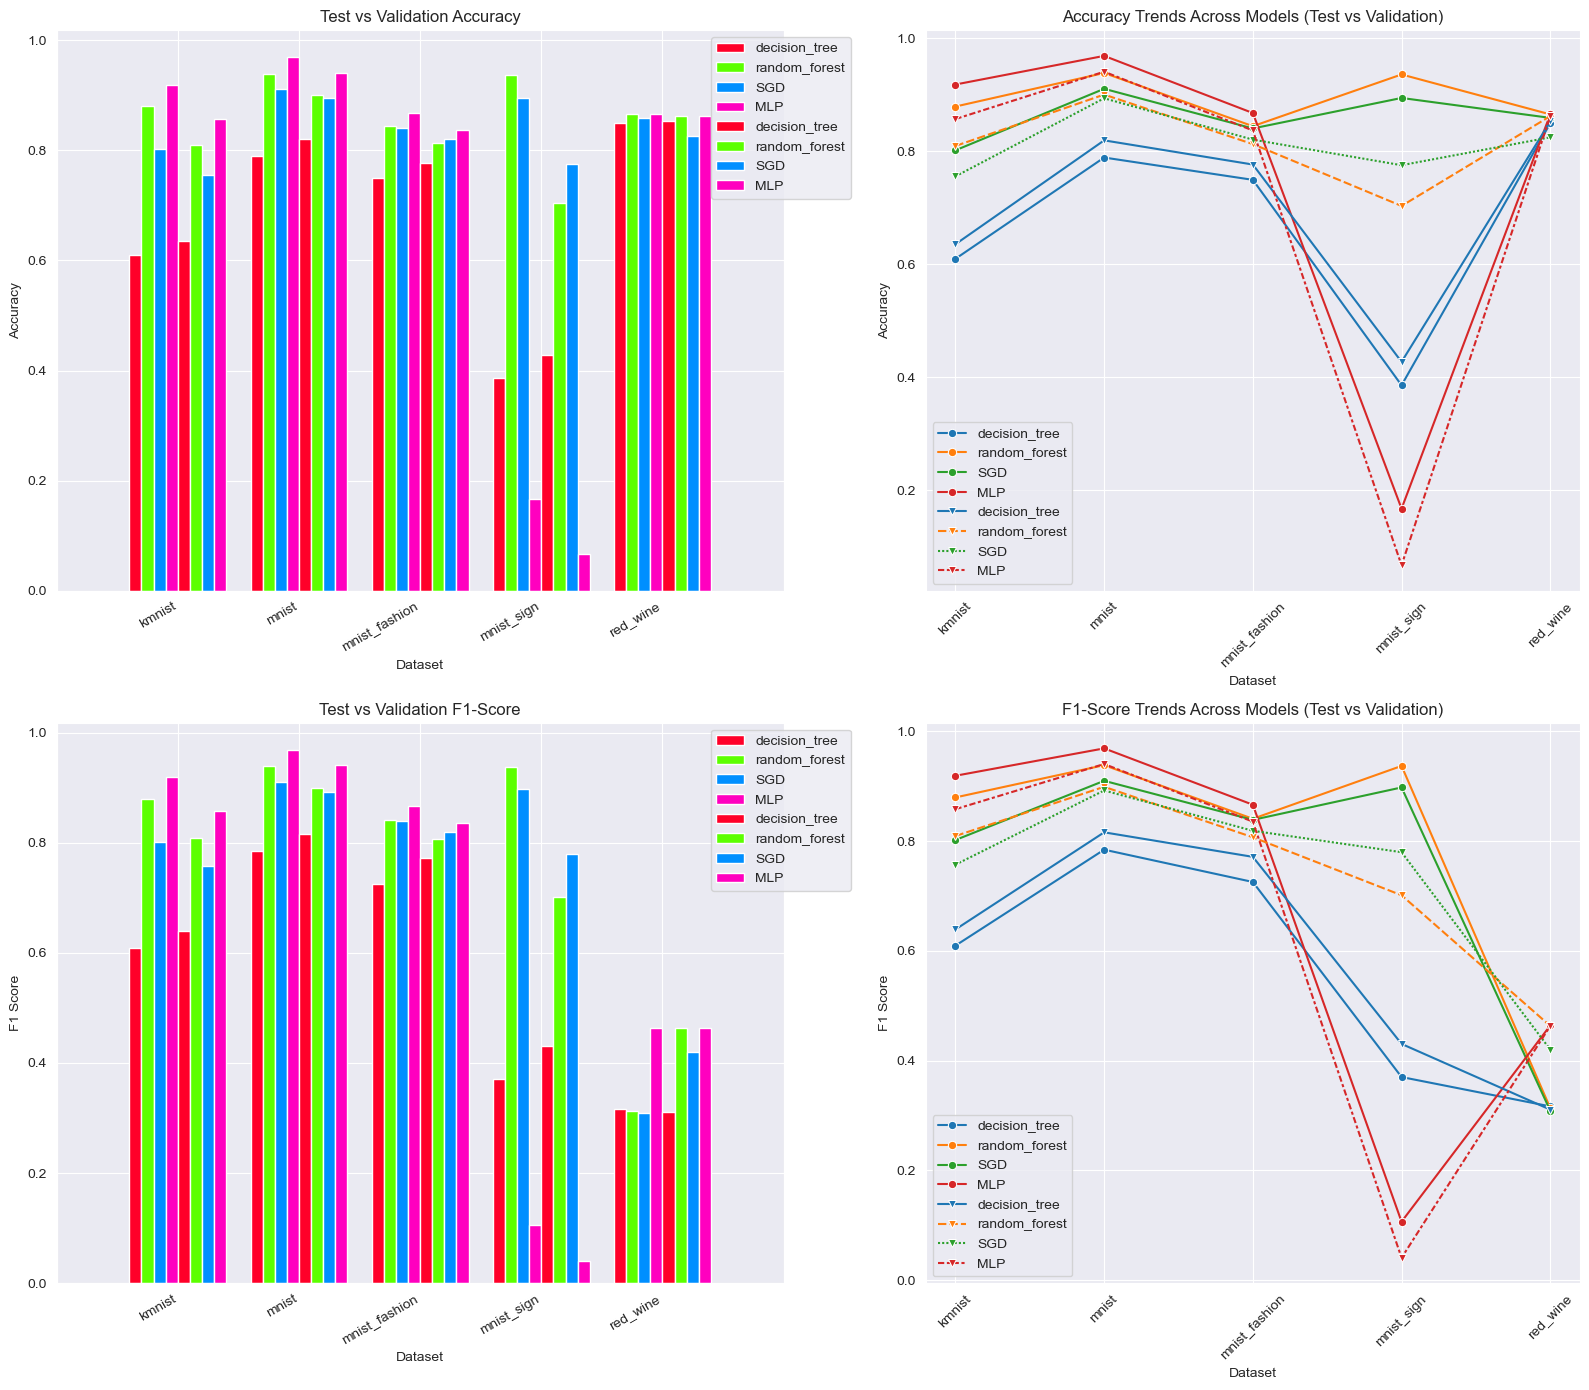

In [28]:
# Extract data into separate tables
test_accuracy_data = []
valid_accuracy_data = []
test_f1_data = []
valid_f1_data = []

for model_name, metrics in model_evaluation_results.items():
    for i, dataset in enumerate(metrics["dataset_name"]):  # Iterate over datasets
        test_accuracy_data.append({"Dataset": dataset, model_name: round(metrics["test_accuracy"][i], 4)})
        valid_accuracy_data.append({"Dataset": dataset, model_name: round(metrics["final_cv_accuracy_mean"][i], 4)})
        test_f1_data.append({"Dataset": dataset, model_name: round(metrics["test_f1"][i], 4)})
        valid_f1_data.append({"Dataset": dataset, model_name: round(metrics["final_cv_f1_mean"][i], 4)})

# Convert lists into DataFrames
test_accuracy_df = pd.DataFrame(test_accuracy_data).groupby("Dataset").mean()
valid_accuracy_df = pd.DataFrame(valid_accuracy_data).groupby("Dataset").mean()
test_f1_df = pd.DataFrame(test_f1_data).groupby("Dataset").mean()
valid_f1_df = pd.DataFrame(valid_f1_data).groupby("Dataset").mean()

# Display the tables
print("Test Accuracy Table:\n", test_accuracy_df)
print("\nValidation Accuracy Table:\n", valid_accuracy_df)
print("\nTest F1 Table:\n", test_f1_df)
print("\nValidation F1 Table:\n", valid_f1_df)

# Set figure size
plt.figure(figsize=(16, 14))

# Adjust width ratios
gs = gridspec.GridSpec(2, 2, width_ratios=[10, 9])

# Graph 1: Test vs Validation Accuracy
plt.subplot(gs[0, 0])
test_accuracy_df.plot(kind="bar", position=1, width=0.4, label="Test", ax=plt.gca(), cmap="gist_rainbow")
valid_accuracy_df.plot(kind="bar", position=0, width=0.4, label="Train", ax=plt.gca(), cmap="gist_rainbow")
plt.title("Test vs Validation Accuracy")
plt.ylabel("Accuracy")
plt.xticks(ticks=range(-1, len(test_accuracy_df.index) + 1), labels=["", *test_accuracy_df.index, ""], rotation=30,
           ha="right")
plt.legend(loc=(0.9, 0.7))

# Graph 2: Test vs Validation F1-Score
plt.subplot(gs[1, 0])
test_f1_df.plot(kind="bar", position=1, width=0.4, label="Test", ax=plt.gca(), cmap="gist_rainbow")
valid_f1_df.plot(kind="bar", position=0, width=0.4, label="Train", ax=plt.gca(), cmap="gist_rainbow")
plt.title("Test vs Validation F1-Score")
plt.ylabel("F1 Score")
plt.xticks(ticks=range(-1, len(test_f1_df.index) + 1), labels=["", *test_f1_df.index, ""], rotation=30, ha="right")
plt.legend(loc=(0.9, 0.7))

# Graph 3: Accuracy Trends Across Models (Test vs Validation)
plt.subplot(gs[0, 1])
sns.lineplot(data=test_accuracy_df, dashes=False, marker="o")
sns.lineplot(data=valid_accuracy_df, dashes=True, marker="v")
plt.title("Accuracy Trends Across Models (Test vs Validation)")
plt.ylabel("Accuracy")
plt.xlabel("Dataset")
plt.xticks(rotation=45)

# Graph 4: F1-Score Trends Across Models (Test vs Validation)
plt.subplot(gs[1, 1])
sns.lineplot(data=test_f1_df, dashes=False, marker="o")
sns.lineplot(data=valid_f1_df, dashes=True, marker="v")
plt.title("F1-Score Trends Across Models (Test vs Validation)")
plt.ylabel("F1 Score")
plt.xlabel("Dataset")
plt.xticks(rotation=45)

# Adjust layout and show plots
plt.tight_layout()
plt.show()

Ranking both test and validations sets on accuracy and f1-score

In [29]:
ranks_df1 = test_accuracy_df.rank(method="min", ascending=False, axis=1)
ranks_df2 = valid_accuracy_df.rank(method="min", ascending=False, axis=1)
ranks_df3 = test_f1_df.rank(method="min", ascending=False, axis=1)
ranks_df4 = valid_f1_df.rank(method="min", ascending=False, axis=1)
print("Test Accuracy Rank:", ranks_df1, sep="\n")
print("\nValidation Accuracy Rank:", ranks_df2, sep="\n")
print("\nTest F1 Rank:", ranks_df3, sep="\n")
print("\nValidation F1 Rank:", ranks_df4, sep="\n")

Test Accuracy Rank:
               decision_tree  random_forest  SGD  MLP
Dataset                                              
kmnist                   4.0            2.0  3.0  1.0
mnist                    4.0            2.0  3.0  1.0
mnist_fashion            4.0            2.0  3.0  1.0
mnist_sign               3.0            1.0  2.0  4.0
red_wine                 4.0            1.0  3.0  1.0

Validation Accuracy Rank:
               decision_tree  random_forest  SGD  MLP
Dataset                                              
kmnist                   4.0            2.0  3.0  1.0
mnist                    4.0            2.0  3.0  1.0
mnist_fashion            4.0            3.0  2.0  1.0
mnist_sign               3.0            2.0  1.0  4.0
red_wine                 3.0            1.0  4.0  1.0

Test F1 Rank:
               decision_tree  random_forest  SGD  MLP
Dataset                                              
kmnist                   4.0            2.0  3.0  1.0
mnist               

## Task 4: Reflection

This experiment compared the performance of **Decision Tree**, **Random Forest**, **Stochastic Gradient Descent (SGD)**, and **Multi-Layer Perceptron (MLP)** models across five datasets: **kmnist**, **mnist**, **mnist_fashion**, **mnist_sign**, and **red_wine**. The results highlight the varying effectiveness of these models depending on the dataset characteristics.

**MLP** consistently achieved the highest accuracy and F1 scores on most datasets, particularly the image-based ones (kmnist, mnist, mnist_fashion). This suggests **MLP's** strong capability in learning complex patterns within image data. **Random Forest** also performed exceptionally well, often ranking second, demonstrating its robustness and generalization ability. **Decision Trees** tended to underperform, likely due to their sensitivity to overfitting, especially on complex datasets. **SGD** showed reasonable performance, particularly on the mnist and mnist_fashion datasets, indicating its effectiveness in handling high-dimensional data.

The mnist_sign dataset presented a unique challenge. **MLP's** performance was notably poor, while **Random Forest** and **SGD** excelled. This discrepancy suggests that **MLP** struggled with the specific features of this dataset, possibly due to its architecture not being optimized for sign language recognition. The red_wine dataset also revealed interesting results, with **MLP** and **Random Forest** achieving similar accuracy, but **MLP** demonstrating a significantly higher F1 score, implying better handling of class imbalance.

I chose accuracy and F1-score as evaluation metrics because they offer complementary insights. Accuracy provides a general measure of correct predictions, while F1-score, the harmonic mean of precision and recall, is crucial when dealing with imbalanced datasets or when both false positives and false negatives are important. In this project, particularly with the red_wine dataset, the F1-score helped reveal the models' ability to handle potential class imbalances more effectively than accuracy alone.

Running this experiment using my custom `HyperParamClassifier` class provided valuable experience in building and evaluating an ensemble learning model. It highlighted the impact of hyperparameter tuning and model aggregation on overall performance. By randomly sampling hyperparameters and training multiple base estimators, I observed how different configurations influenced accuracy and F1-scores across diverse datasets. This process underscored the importance of understanding the underlying algorithms and their sensitivity to parameter variations.